In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch
import torchvision
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [2]:
# baja y lee los datos
training = torchvision.datasets.FashionMNIST(root="./", train=True, download=True)
train_loader = torch.utils.data.DataLoader(training,shuffle=True)

testing = torchvision.datasets.FashionMNIST(root="./", train=False, download=True, 
                                            transform=torchvision.transforms.Normalize((0), (1.0)))
testing_loader = torch.utils.data.DataLoader(testing, shuffle=True)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


torch.Size([60000, 28, 28])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


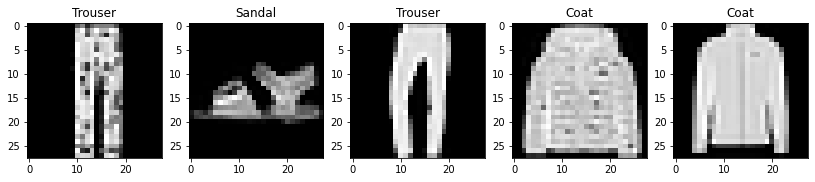

In [3]:
# muestra algunos ejemplos
print(train_loader.dataset.data.size())
print(train_loader.dataset.classes)
n_items = train_loader.dataset.data.size()[0]
random_items = np.random.choice(np.arange(n_items), 5)

plt.figure(figsize=(14,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    item  = random_items[i]
    plt.imshow(train_loader.dataset.data[item],cmap='gray')
    plt.title(train_loader.dataset.classes[train_loader.dataset.targets[item]] )

In [0]:
# Selecciona y normaliza 600 para entrenar
train  = train_loader.dataset.data[:600].float()
Y_train = train_loader.dataset.targets[:600].float()

test  = testing_loader.dataset.data[:600].float()
Y_test = testing_loader.dataset.targets[:600].float()

mean = train.mean(dim=0)
std = train.std(dim=0)
std[std==0]=1.0

for i in range(len(train)):
    train[i] = (train[i]-mean)/std

mean = test.mean(dim=0)
std = test.std(dim=0)
std[std==0]=1.0

for i in range(len(test)):
    test[i] = (test[i]-mean)/std

In [35]:
X_train = train.unsqueeze(1)
X_test = test.unsqueeze(1)

print(np.shape(X_train), np.shape(X_test))


torch.Size([600, 1, 28, 28]) torch.Size([600, 1, 28, 28])


In [141]:
X_new = X_train # necesario para que las dimensiones sean [batch, channel, width]
feature_maps = torch.autograd.Variable(torch.Tensor(X_new).float())

n =  torch.nn.Conv2d(1, 20, 5, stride=1, padding=1)# in-channels = 1, out-channels = 4, kernel=4
feature_maps = n(feature_maps)

n =  torch.nn.MaxPool2d(2,2)# in-channels = 1, out-channels = 4, kernel=4
feature_maps = n(feature_maps)

print(feature_maps.size())

n =  torch.nn.Linear(13,20)
feature_maps = n(feature_maps)

n =  torch.nn.Conv2d(20, 5, 5, stride=1,  padding=1)# in-channels = 1, out-channels = 4, kernel=4
feature_maps = n(feature_maps)

n =  torch.nn.Flatten()
feature_maps = n(feature_maps)

print(feature_maps.size())


torch.Size([600, 20, 13, 13])
torch.Size([600, 990])


In [0]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1,20,5, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2,2),
    torch.nn.Linear(13,20),
    torch.nn.Conv2d(20, 5, 5, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(990,10)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2) #lr: learning rate
epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)

for epoch in range(epochs):
    X_new = X_train
    inputs = torch.autograd.Variable(torch.Tensor(X_new).float())
    target = torch.autograd.Variable(torch.Tensor(Y_train).long())
    
    optimizer.zero_grad()
    out = model(inputs)
    out = torch.squeeze(out)
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(Y_train, Y_predicted, average='macro')
    
    X_new = X_test
    inputs_test = torch.autograd.Variable(torch.Tensor(X_new).float())
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(Y_test, Y_predicted_test, average='macro')

Text(0, 0.5, 'loss')

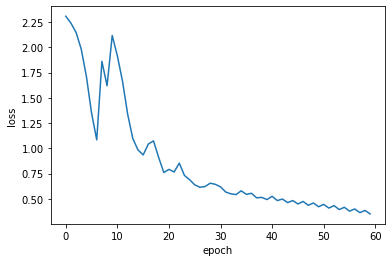

In [143]:
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')

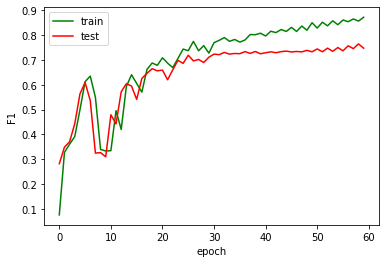

In [144]:
plt.plot(np.arange(epochs), F1_values_train, 'g',label='train')
plt.plot(np.arange(epochs), F1_values_test, 'r',label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()